In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import hdbscan
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score, adjusted_rand_score
import seaborn as sns

import folium
import numpy as np
from IPython.display import display

In [2]:
here = Path.cwd()
root = next(p for p in [here, *here.parents] if (p / "data" / "processed").exists())
full_df = pd.read_csv(root / "data" / "processed" / "state1" / "ios_left.csv", header=0)
geo_cols = full_df[["eventStartLatitude", "eventStartLongitude",
                        "eventEndLatitude", "eventEndLongitude"]].copy()
full_df = full_df.drop(columns=['is_ios', 'eventType', 'eventStart', 'eventEnd'])

def assign_manual_label_3class(row):
    angle = row['gyroAngleChange']
    if angle < 60:
        return 0  # Lane Change
    elif angle < 140:
        return 1  # Left Turn
    else:
        return 2  # U-Turn

full_df['manual_label'] = full_df.apply(assign_manual_label_3class, axis=1)

print("Manual label distribution:")
print(full_df['manual_label'].value_counts().sort_index())
print()

print(full_df.columns.tolist())
features = [
    'angle_norm',                        
    'radius_log',                        
    'turn_intensity',                    
    'gyro_angular_change_per_second',   
    'eventDurationSeconds',            
]
df = full_df[features].copy()
print(df.columns.to_list())
print(df.shape)

Manual label distribution:
manual_label
0     809
1    2555
2     160
Name: count, dtype: int64

['eventSampleSpeed', 'eventDurationSeconds', 'eventMilesDriven', 'eventStartLatitude', 'eventStartLongitude', 'eventEndLatitude', 'eventEndLongitude', 'eventGPSSignalStrength', 'eventStartSpeed', 'eventEndSpeed', 'memsMedianHorizontalNorm', 'gyro_angular_change_per_second', 'gyroAngleChange', 'mems_radius', 'dv', 'turn_intensity', 'angle_norm', 'radius_log', 'manual_label']
['angle_norm', 'radius_log', 'turn_intensity', 'gyro_angular_change_per_second', 'eventDurationSeconds']
(3524, 5)


In [4]:
def calculate_gini_score(labels) -> float:
    # Exclude HDBSCAN/DBSCAN noise
    labels = np.asarray(labels)
    mask = labels != -1
    if mask.sum() == 0:
        return 0.0
    # Counts per cluster
    counts = np.bincount(labels[mask])
    counts = counts[counts > 0].astype(float)
    if counts.size <= 1:
        return 0.0
    # Pairwise Gini
    G = np.abs(counts[:, None] - counts[None, :]).sum() / (2 * counts.size * counts.sum())
    # Normalize so 1.0 = maximally imbalanced given k clusters
    Gmax = (counts.size - 1) / counts.size
    return float(G / Gmax) if Gmax else 0.0
    

In [7]:
X_scaled = StandardScaler().fit_transform(df)
scaled_df = pd.DataFrame(X_scaled, columns=df.columns, index=df.index)
features_to_plot = features[:]   # keep plotting consistent with model inputs

In [8]:
results_list = []
run_id = 0  # ← Add counter for tracking
run_labels = {}  # ✅ Store labels for plotting

In [ ]:
# k means model


# possible k values
for k in [2,3,4,5,6,7,8]:
    kmeans_final = KMeans(n_clusters=k, random_state=42)
    kmeans_final.fit(X_scaled)
    final_labels = kmeans_final.labels_

    sil_score = silhouette_score(X_scaled, final_labels)
    noise_percentage = 0.0
    gini_score = calculate_gini_score(final_labels)
    ari_score = adjusted_rand_score(full_df['manual_label'], final_labels)  # ✅ Add ARI

    run_labels[run_id] = final_labels  # ✅ Store labels


    results_list.append({
        'run_id': run_id,  # ← Add this
        'model': 'kmeans',
        'sil. #': sil_score,
        'Gini': gini_score,
        'noise %': noise_percentage,
        'clust. #': k,
        'ARI': ari_score,  #Add ARI
    })
    run_id += 1  # ← Increment


In [9]:
N_total = X_scaled.shape[0]

In [10]:
# DBSCAN
for eps in np.linspace(0.1, 1.0, 20):
    for min_pts in range(20, 80):
        labels = DBSCAN(eps=float(eps), min_samples=int(min_pts), n_jobs=-1).fit_predict(X_scaled)
        mask = labels != -1
        labels_nn = labels[mask]
        n_clusters = len(np.unique(labels_nn)) if labels_nn.size > 0 else 0  # ← Fix
        n_noise = int((labels == -1).sum())
        noise_pct = (n_noise / N_total) * 100.0

        # ← Better edge case handling
        if n_clusters < 2 or labels_nn.size < 2:
            continue

        sil = silhouette_score(X_scaled[mask], labels_nn)
        gini = calculate_gini_score(labels)
        ari = adjusted_rand_score(full_df['manual_label'], labels)  # ✅ Add ARI

        run_labels[run_id] = labels  # ✅ Store labels


        results_list.append({
            'run_id': run_id,  # ← Add this
            'model': 'dbscan',
            'HP (eps)': float(eps),
            'HP (min_samp)': int(min_pts),
            'clust. #': int(n_clusters),
            'sil. #': float(sil),
            'Gini': float(gini),
            'noise %': float(noise_pct),
            'ARI': float(ari),  # ✅ Now ari is defined
        })
        run_id += 1  # ← Increment

In [50]:
# HDBSCAN
# Track which noise counts we've already seen for HDBSCAN
seen_noise_counts = set()

for min_samp in range(2, 30):
    for min_cluster_size in range(15, 80):

        # Optional: prune combos that tend not to help
        if min_samp > min_cluster_size:
            continue

        clusterer = hdbscan.HDBSCAN(
            min_samples=min_samp,
            min_cluster_size=min_cluster_size,
            metric='euclidean'
        )
        clusterer.fit(X_scaled)
        labels = clusterer.labels_

        non_noise_mask = labels != -1
        labels_non_noise = labels[non_noise_mask]
        n_non_noise = labels_non_noise.size
        n_clusters = len(np.unique(labels_non_noise)) if n_non_noise else 0

        n_noise = np.count_nonzero(labels == -1)
        noise_percentage = (n_noise / N_total) * 100.0

        # 🔹 Skip this run entirely if we've already seen this noise level
        if n_noise in seen_noise_counts:
            continue
        seen_noise_counts.add(n_noise)

        # ← Better filtering
        if n_clusters < 2 or n_clusters > 5:
            continue

        # Default
        sil_score = np.nan

        # Only try silhouette when it makes sense
        if noise_percentage < 15 and n_clusters >= 2 and n_non_noise >= 2:
            try:
                sil_score = silhouette_score(X_scaled[non_noise_mask], labels_non_noise)
            except ValueError:
                sil_score = np.nan

        gini_score = calculate_gini_score(labels)
        ari_score = adjusted_rand_score(full_df['manual_label'], labels)  # ✅ Add ARI

        run_labels[run_id] = labels  # ✅ Store labels

        results_list.append({
            'run_id': run_id,  # ← Add this
            'model': 'hdbscan',
            'HP (min_samp)': min_samp,
            'HP (min_clust)': min_cluster_size,
            'sil. #': sil_score,
            'Gini': gini_score,
            'noise %': noise_percentage,
            'clust. #': n_clusters,
            'ARI': ari_score,  # ✅ Add ARI

        })
        run_id += 1  # ← Increment

/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.14/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.14/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.14/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shazi/Documents/VS Code/Arity - BTT Project 1/ARITY-BTT-PROJECT-1/.venv/lib/python3.14/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' 

In [11]:
results_df = pd.DataFrame(results_list)
results_df.head()

,run_id,model,HP (eps),HP (min_samp),clust. #,sil. #,Gini,noise %,ARI
0,0,dbscan,0.242105,20,2,0.009691,0.929936,82.179342,-0.110604
1,1,dbscan,0.242105,21,2,0.175225,0.774697,83.626561,-0.116866
2,2,dbscan,0.242105,22,2,0.186624,0.780347,85.272418,-0.113769
3,3,dbscan,0.242105,23,3,0.027666,0.793548,86.804767,-0.111953
4,4,dbscan,0.242105,24,4,0.309420,0.581197,88.933031,-0.109386


In [15]:
results_df = pd.DataFrame(results_list).sort_values(
    by=['ARI', 'Gini', 'noise %', 'sil. #', 'clust. #'], 
    ascending=[False, True, True, False, False]
)

# Don't reset_index - you already have run_id in the data!
filtered_results = results_df.copy()

# Apply filters
#filtered_results = filtered_results[filtered_results['noise %'] <= 20.0]
#filtered_results = filtered_results[filtered_results['clust. #'].isin([3, 4])]
#filtered_results = filtered_results[filtered_results['sil. #'] > 0.3]
filtered_results.head(100)

,run_id,model,HP (eps),HP (min_samp),clust. #,sil. #,Gini,noise %,ARI
131,131,dbscan,0.573684,41,2,0.413550,0.815139,25.397276,0.351305
134,134,dbscan,0.573684,44,3,0.364577,0.897839,27.780931,0.349228
210,210,dbscan,0.715789,78,2,0.401314,0.828380,23.609535,0.348270
102,102,dbscan,0.526316,33,2,0.421190,0.812060,27.525539,0.348250
211,211,dbscan,0.715789,79,2,0.402092,0.835575,24.063564,0.347807
...,...,...,...,...,...,...,...,...,...
154,154,dbscan,0.573684,64,2,0.509283,0.911608,41.572077,0.292404
157,157,dbscan,0.573684,67,2,0.527402,0.931309,42.990919,0.291683
155,155,dbscan,0.573684,65,2,0.510237,0.911349,41.742338,0.291099
54,54,dbscan,0.431579,22,2,0.475224,0.844338,35.102157,0.288908


In [16]:
runs_to_plot = filtered_results['run_id'].head(5).tolist()
filtered_results = filtered_results.loc[filtered_results['run_id'].isin(runs_to_plot)]
filtered_results.head()

,run_id,model,HP (eps),HP (min_samp),clust. #,sil. #,Gini,noise %,ARI
131,131,dbscan,0.573684,41,2,0.413550,0.815139,25.397276,0.351305
134,134,dbscan,0.573684,44,3,0.364577,0.897839,27.780931,0.349228
210,210,dbscan,0.715789,78,2,0.401314,0.828380,23.609535,0.348270
102,102,dbscan,0.526316,33,2,0.421190,0.812060,27.525539,0.348250
211,211,dbscan,0.715789,79,2,0.402092,0.835575,24.063564,0.347807


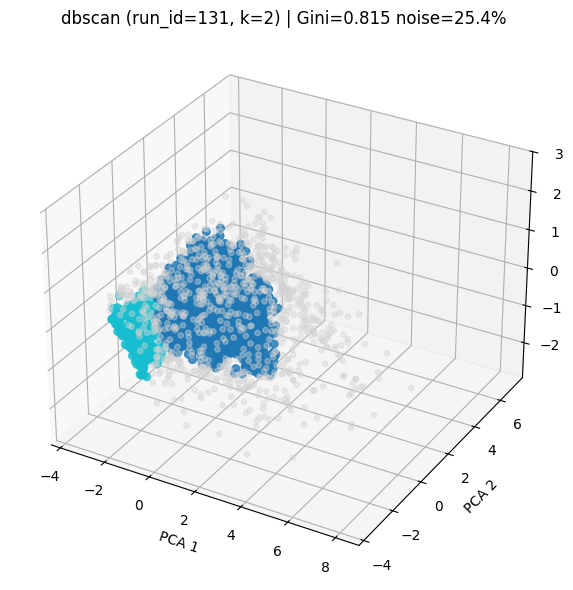

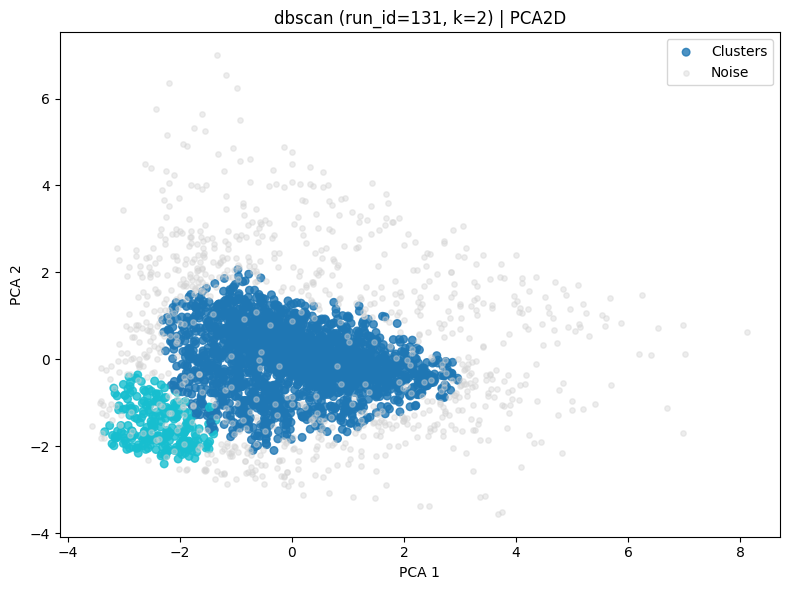

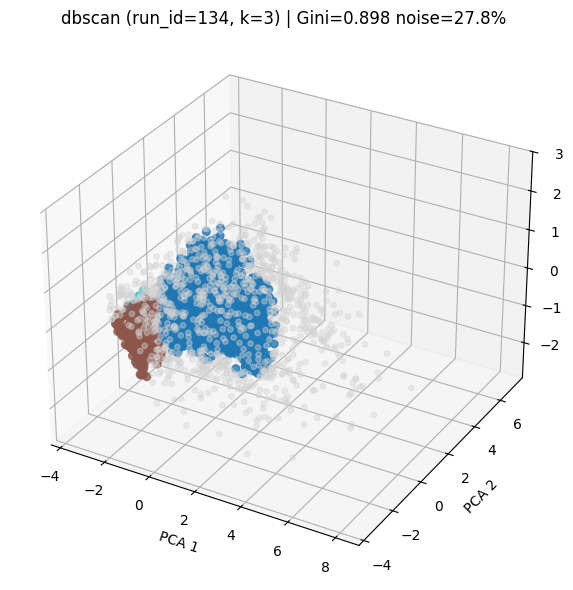

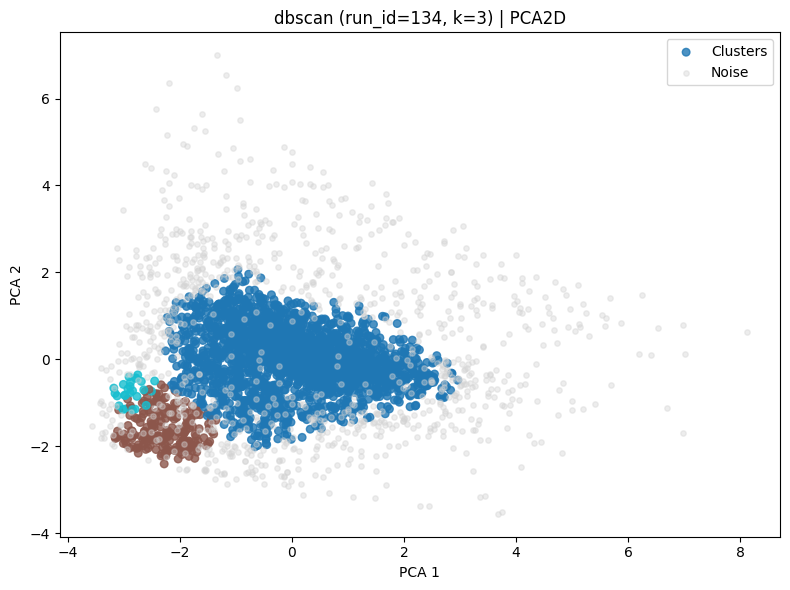

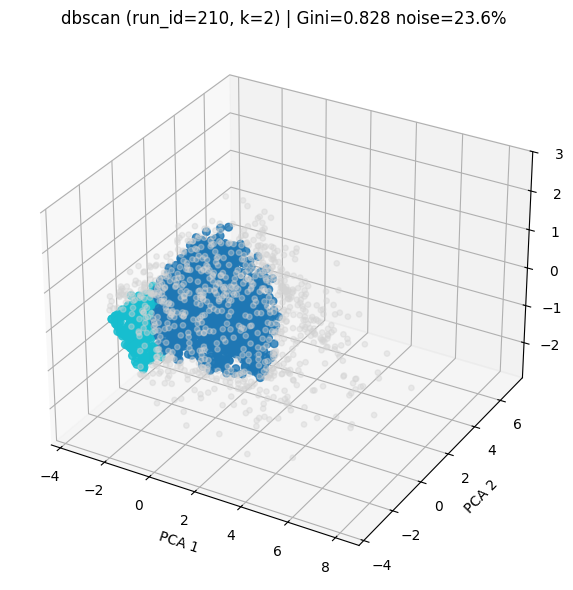

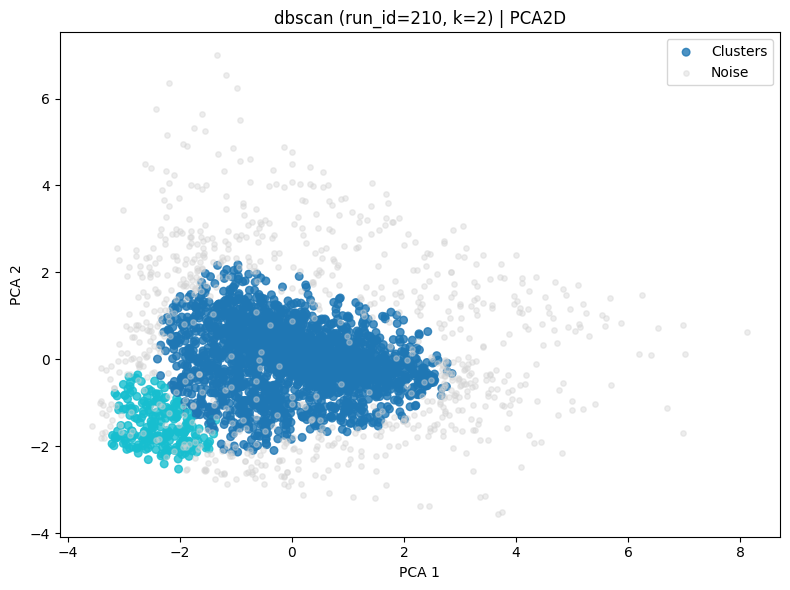

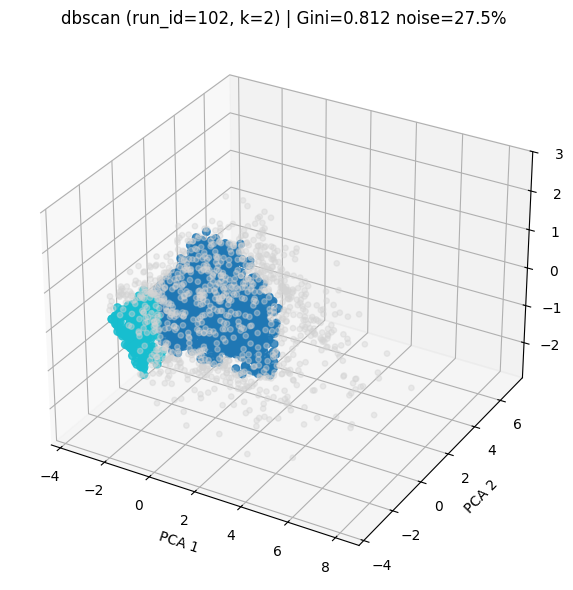

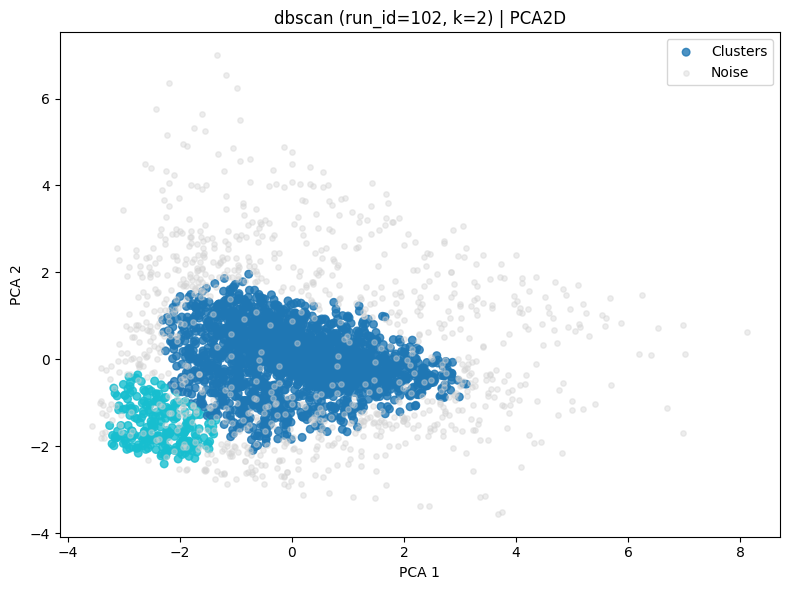

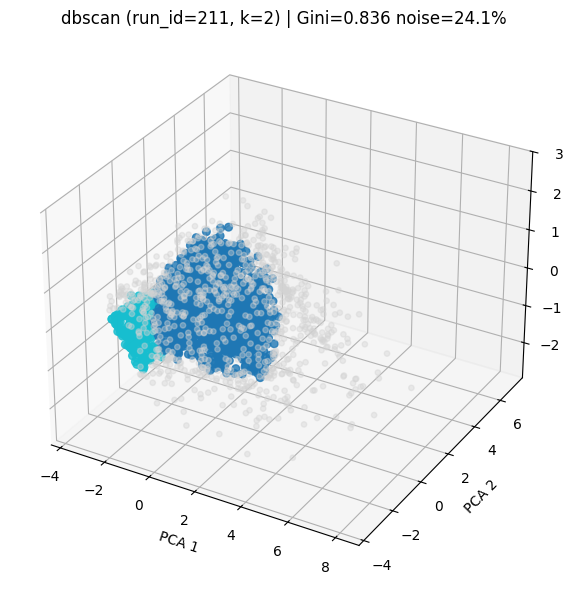

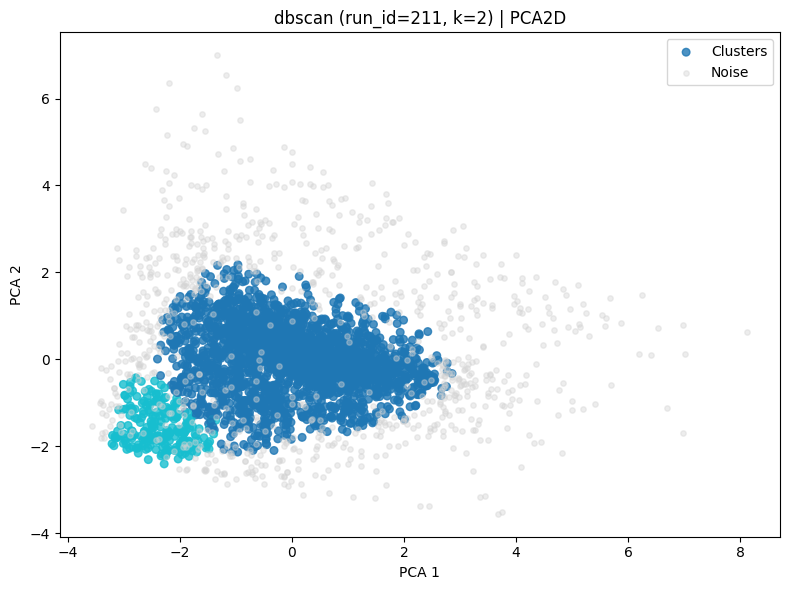

/var/folders/md/7qhzsnh55gzclxjx6wytnlh00000gn/T/ipykernel_56037/1539933878.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


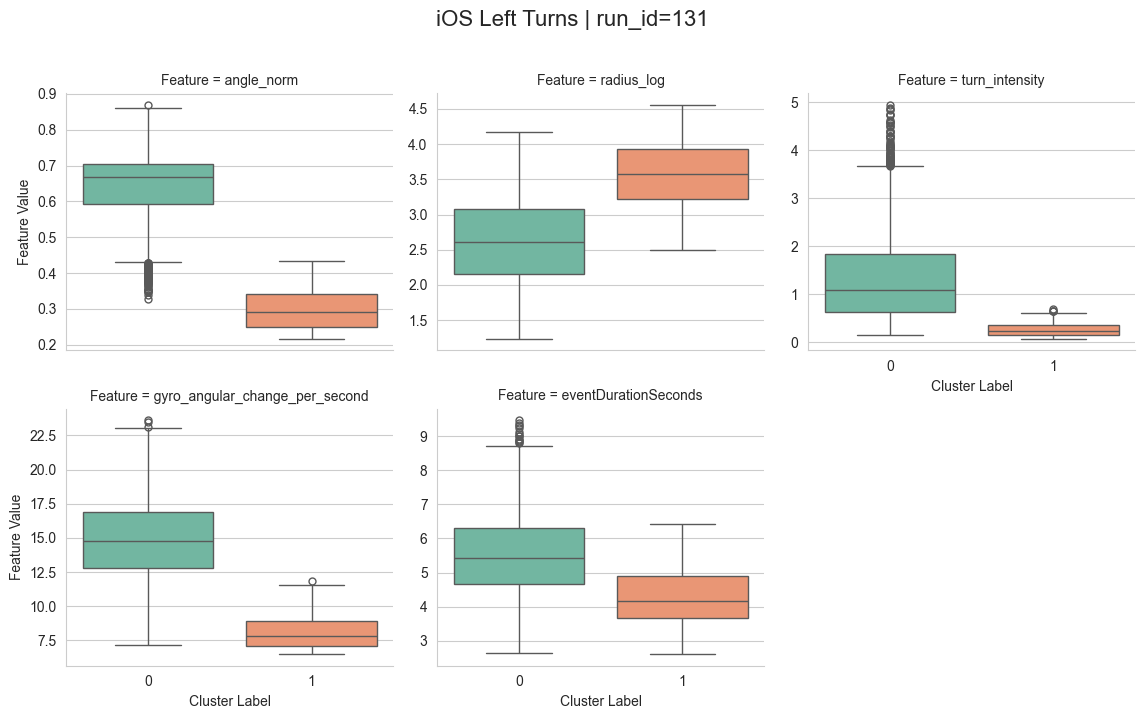

/var/folders/md/7qhzsnh55gzclxjx6wytnlh00000gn/T/ipykernel_56037/1539933878.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


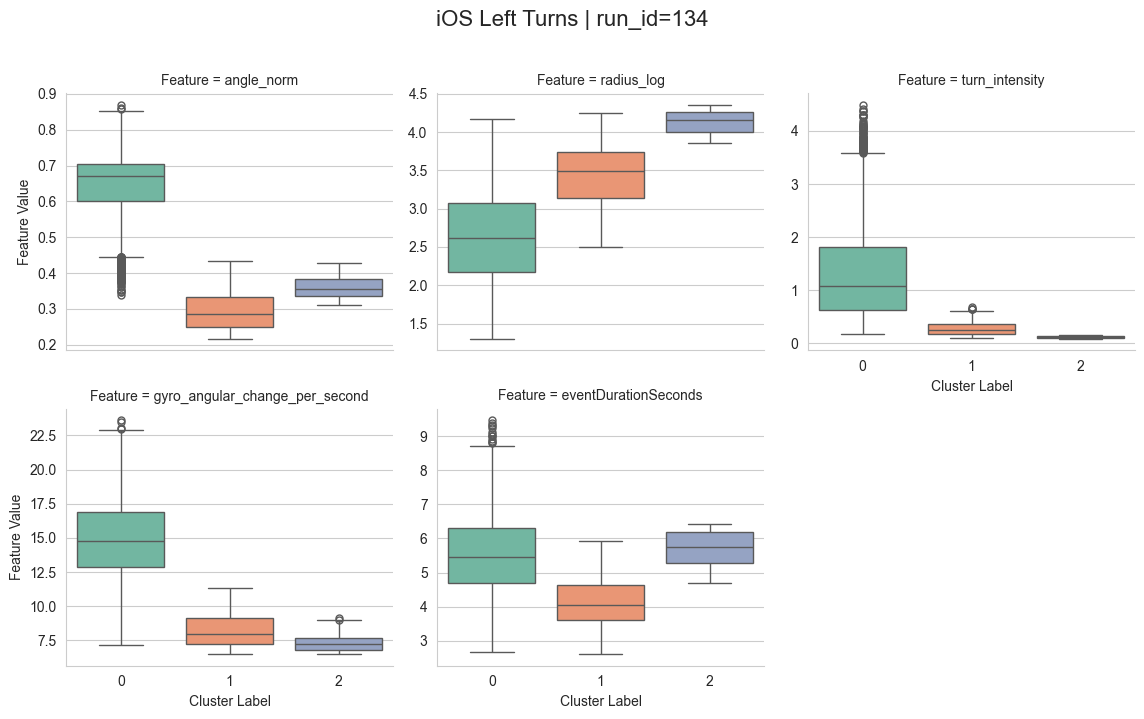

/var/folders/md/7qhzsnh55gzclxjx6wytnlh00000gn/T/ipykernel_56037/1539933878.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


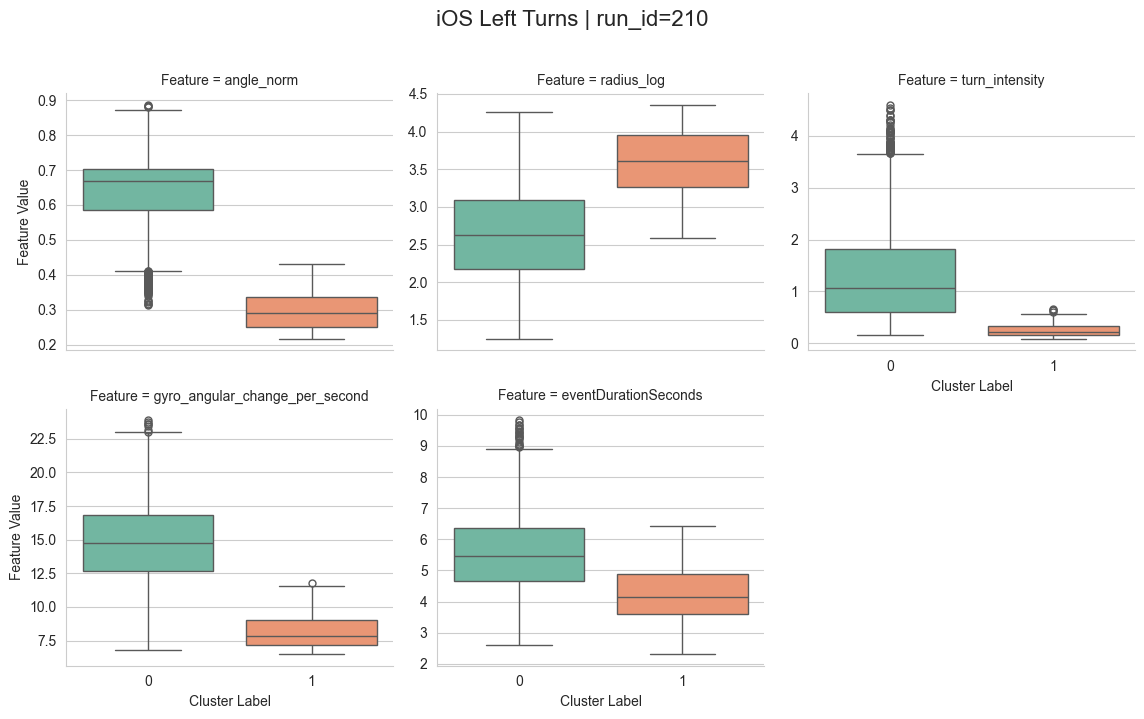

/var/folders/md/7qhzsnh55gzclxjx6wytnlh00000gn/T/ipykernel_56037/1539933878.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


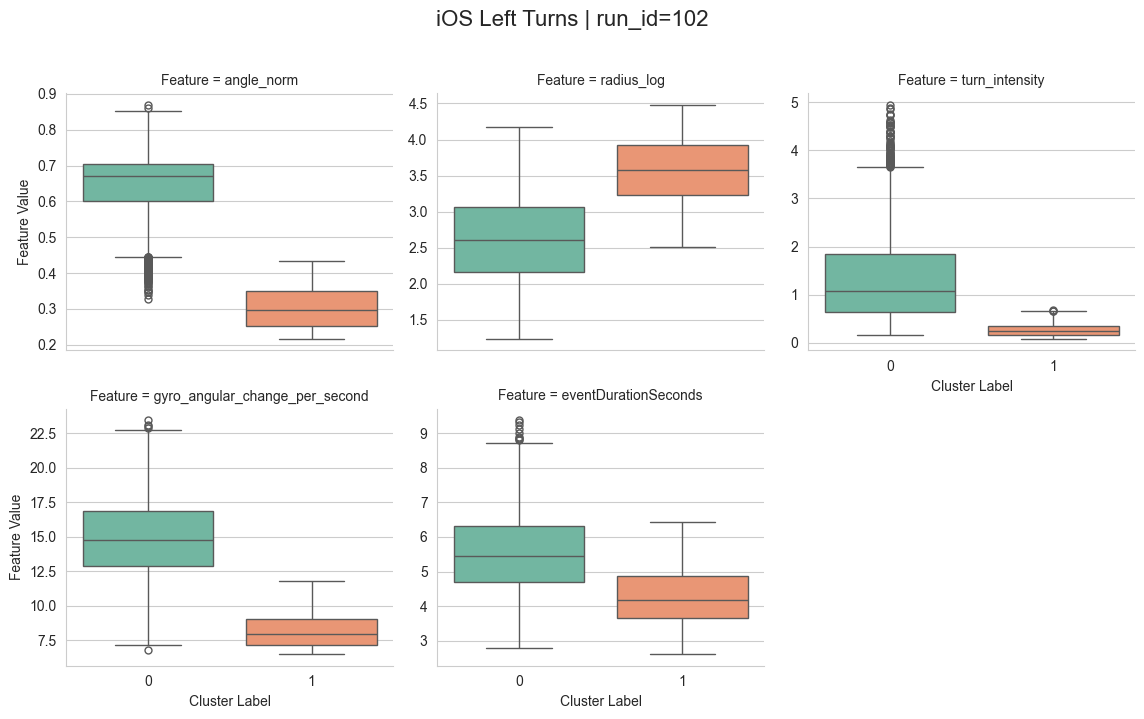

/var/folders/md/7qhzsnh55gzclxjx6wytnlh00000gn/T/ipykernel_56037/1539933878.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


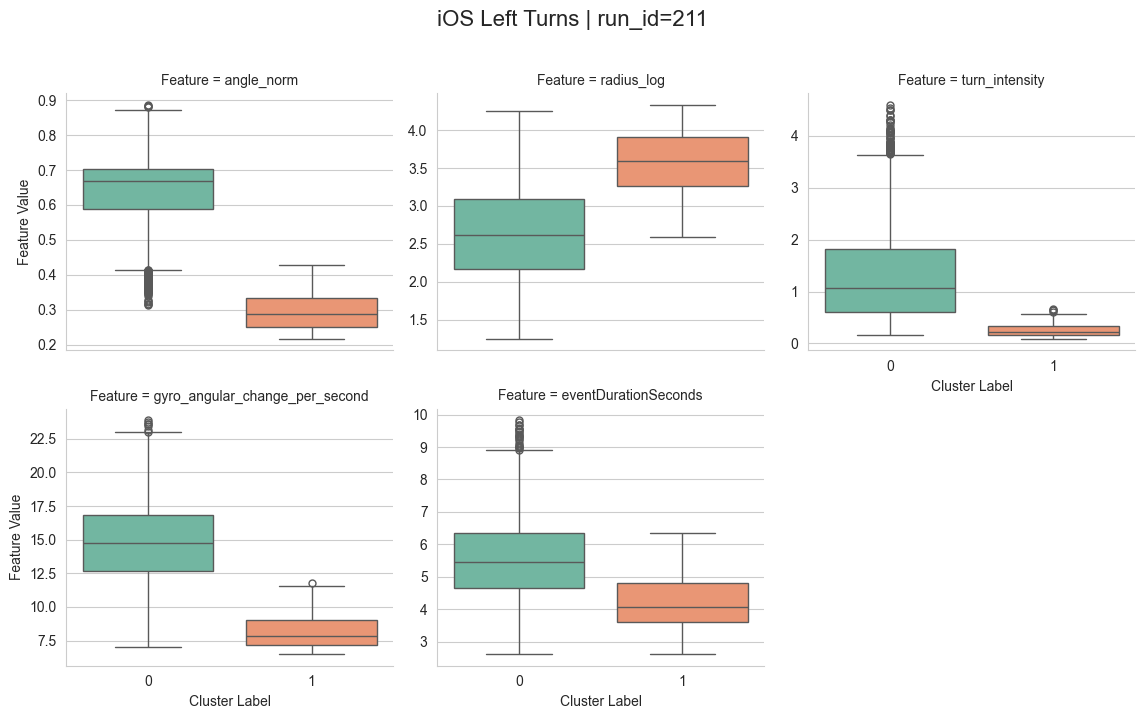

In [17]:
# --- CONFIG ---
plot_cols = features

# --- helpers ---------------------------------------------------------------
def build_clusterer(row):
    model = row['model']
    if model == 'kmeans':
        return KMeans(n_clusters=int(row['clust. #']), random_state=42)
    if model == 'dbscan':
        return DBSCAN(eps=float(row['HP (eps)']),
                      min_samples=int(row['HP (min_samp)']),
                      n_jobs=-1)
    if model == 'hdbscan':
        return hdbscan.HDBSCAN(min_samples=int(row['HP (min_samp)']),
                               min_cluster_size=int(row['HP (min_clust)'])
                               if pd.notna(row['HP (min_clust)']) else None)
    raise ValueError(f"Unknown model '{model}' for run_id {row['run_id']}")

def attach_clusters(labels):
    df_with_clusters = full_df.copy()
    df_with_clusters['Cluster_Label'] = labels
    return df_with_clusters[df_with_clusters['Cluster_Label'] != -1].copy()

# --- 1) filter the runs once -----------------------------------------------
runs = (
    filtered_results
    .loc[filtered_results['run_id'].isin(runs_to_plot)]
    .copy()
)
if runs.empty:
    raise ValueError(f"No rows found for run_id(s) {runs_to_plot}")

# fit each clusterer exactly once and cache its labels
run_labels = {}
for _, row in runs.iterrows():
    clusterer = build_clusterer(row)
    run_labels[row['run_id']] = clusterer.fit_predict(X_scaled)

# --- 2) PCA plots ----------------------------------------------------------
pca3 = PCA(n_components=3).fit_transform(X_scaled)
pca2 = PCA(n_components=2).fit_transform(X_scaled)

for _, row in runs.iterrows():
    run_id = row['run_id']
    labels = run_labels[run_id]
    core_mask = labels != -1
    noise_mask = labels == -1
    title_bits = f"{row['model']} (run_id={run_id}, k={row['clust. #']})"

    # 3D
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pca3[core_mask, 0], pca3[core_mask, 1], pca3[core_mask, 2],
               c=labels[core_mask], cmap='tab10', s=30, alpha=0.8)
    if noise_mask.any():
        ax.scatter(pca3[noise_mask, 0], pca3[noise_mask, 1], pca3[noise_mask, 2],
                   c='lightgray', s=15, alpha=0.4, label='Noise')
    ax.set_title(f"{title_bits} | Gini={row['Gini']:.3f} noise={row['noise %']:.1f}%")
    ax.set_xlabel('PCA 1'); ax.set_ylabel('PCA 2'); ax.set_zlabel('PCA 3')
    plt.tight_layout(); plt.show()

    # 2D
    plt.figure(figsize=(8, 6))
    plt.scatter(pca2[core_mask, 0], pca2[core_mask, 1],
                c=labels[core_mask], cmap='tab10', s=30, alpha=0.8, label='Clusters')
    if noise_mask.any():
        plt.scatter(pca2[noise_mask, 0], pca2[noise_mask, 1],
                    c='lightgray', s=15, alpha=0.4, label='Noise')
    plt.title(f"{title_bits} | PCA2D")
    plt.xlabel('PCA 1'); plt.ylabel('PCA 2'); plt.legend(); plt.tight_layout(); plt.show()

# --- 3) Box plots ----------------------------------------------------------
for _, row in runs.iterrows():
    run_id = row['run_id']
    labels = run_labels[run_id]
    df_plot = attach_clusters(labels)
    df_plot['Cluster_Label'] = df_plot['Cluster_Label'].astype('category')

    melt_cols = [c for c in plot_cols if c in df_plot.columns]
    if not melt_cols:
        raise ValueError("No overlap between plot_cols and df columns.")

    df_melted = df_plot[['Cluster_Label'] + melt_cols].melt(
        id_vars='Cluster_Label', var_name='Feature', value_name='Value'
    )

    sns.set_style('whitegrid')
    g = sns.catplot(
        data=df_melted,
        x='Cluster_Label',
        y='Value',
        col='Feature',
        kind='box',
        col_wrap=3,
        palette='Set2',
        sharey=False,
        height=3.5,
        aspect=1.1
    )
    g.fig.suptitle(f'iOS Left Turns | run_id={run_id}', y=1.02, fontsize=16)
    g.set_axis_labels('Cluster Label', 'Feature Value')
    plt.tight_layout()
    plt.show()


/var/folders/md/7qhzsnh55gzclxjx6wytnlh00000gn/T/ipykernel_56037/1607607251.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


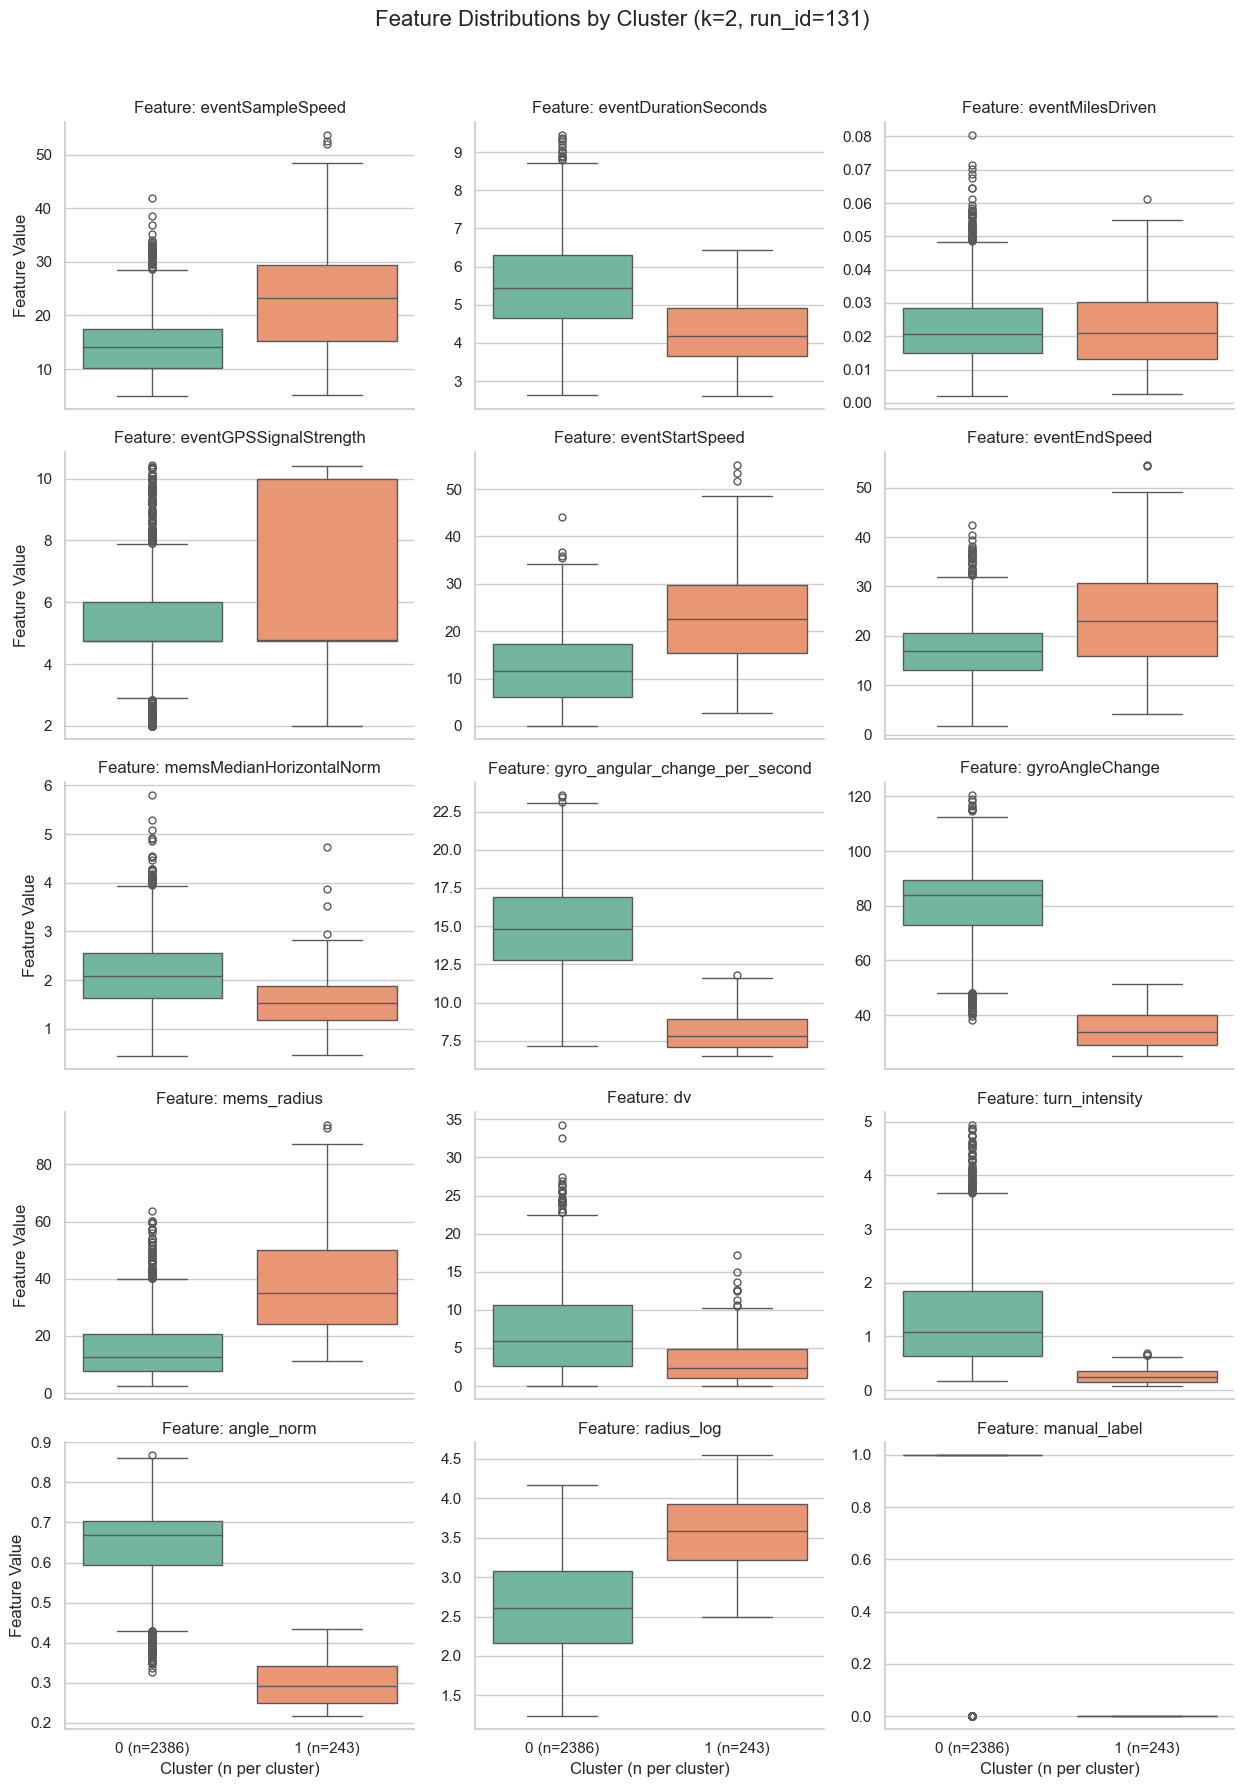

In [18]:
# --- 1) pick which dataframe to use ---
df_with_clusters = full_df.copy()
df_with_clusters['Cluster_Label'] = labels

# pick which run to visualize
run_id = 131

# make sure you’re using the labels from that specific run
labels = run_labels[run_id]          # <--- CRUCIAL LINE

df_with_clusters = full_df.copy()
df_with_clusters['Cluster_Label'] = labels
assert 'Cluster_Label' in df_with_clusters.columns
assert 'Cluster_Label' in df_with_clusters.columns, "You need to attach cluster labels first."

# --- 2) drop noise and build pretty cluster labels with counts ---
df_plot = df_with_clusters[df_with_clusters['Cluster_Label'] != -1].copy()
counts = df_plot['Cluster_Label'].value_counts().sort_index()
label_map = {cl: f"{int(cl)} (n={int(counts.loc[cl])})" for cl in counts.index}
df_plot['Cluster_Str'] = df_plot['Cluster_Label'].map(label_map)

# keep a stable order on x-axis
ordered_xticks = [label_map[cl] for cl in sorted(counts.index)]
df_plot['Cluster_Str'] = pd.Categorical(df_plot['Cluster_Str'], categories=ordered_xticks, ordered=True)

# --- 3) select features to visualize (exclude IDs/GPS/labels) ---
excluded = {'Cluster_Label','Cluster_Str','eventStartLatitude','eventStartLongitude','eventEndLatitude','eventEndLongitude'}
features_to_plot = [c for c in df_plot.columns if c not in excluded and pd.api.types.is_numeric_dtype(df_plot[c])]

# --- 4) reshape to long form for seaborn ---
df_melted = df_plot.melt(
    id_vars='Cluster_Str',
    value_vars=features_to_plot,
    var_name='Feature',
    value_name='Value'
)

# --- 5) plot ---
sns.set(style='whitegrid')
g = sns.catplot(
    data=df_melted,
    x='Cluster_Str',
    y='Value',
    col='Feature',
    kind='box',
    col_wrap=3,
    height=3.5,
    aspect=1.2,
    sharey=False,
    palette='Set2'
)

k = len(counts)
g.fig.suptitle(f'Feature Distributions by Cluster (k={k}, run_id={run_id})', y=1.02, fontsize=16)
g.set_titles('Feature: {col_name}')
g.set_axis_labels('Cluster (n per cluster)', 'Feature Value')
plt.tight_layout()
plt.show()